In [1]:
from src.pde_model.parameters import params
from src.pde_model.SMsolver import BurglaryPDESMSolver
import numpy as np
from src.pde_model.mesh_utils import create_domain_urban, create_domain
from shapely.geometry import Polygon, LineString
import gmsh
import geopandas as gpd
import matplotlib.pyplot as plt

### 1. Standard Simulation

In [ ]:
Nx, Ny = params["Nx"], params["Ny"]
Anoise = 0.1* np.random.rand((Nx+1)* (Ny+1))
rhonoise = 0.1* np.random.rand((Nx+1)* (Ny+1))
msh, ME, cspace = create_domain(params)
solver = BurglaryPDEIMSolver(params,Anoise,rhonoise,msh, ME, cspace)
solver.run()

### 2. Highway Simulation

In [ ]:
Nx, Ny = params["Nx"], params["Ny"]
A0_fun = lambda x, p: np.where(x[1] < p["Ly"]/2,
                               1 + np.exp(-20*(x[1]+x[0]-p["Lx"])**2),
                               1)*p["A_st"]
Bbar_fun = lambda x, p: np.where(x[1] < p["Ly"]/2,
                                 np.exp(-20*(x[1]+x[0]-p["Lx"])**2)*p["Bbar"]+p["Bbar"],
                                 p["Bbar"])

Anoise = 0.01* np.random.rand((Nx+1)* (Ny+1))
rhonoise = 0.1* np.random.rand((Nx+1)* (Ny+1))
msh, ME, cspace = create_domain(params)
solver = BurglaryPDEIMSolver(params, Anoise,rhonoise,msh, ME, cspace, A0_fun=A0_fun, Bbar_fun=Bbar_fun)
solver.run()

### 3. Urban Simulation

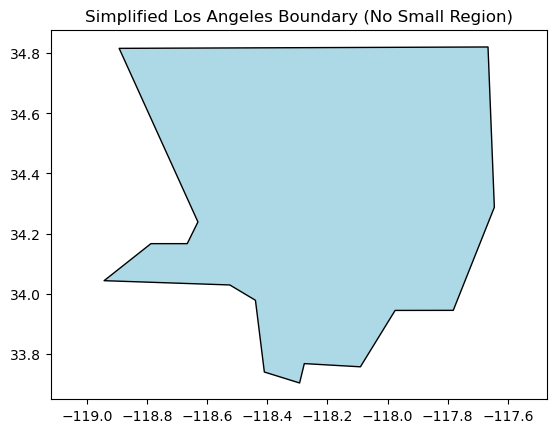

In [2]:
gdf = gpd.read_file("Data/LA_Boundary/LA_simplified.shp")  
geom = gdf.unary_union

gpd.GeoSeries(geom).plot(color='lightblue', edgecolor='black')
plt.title("Simplified Los Angeles Boundary (No Small Region)")
plt.axis("equal")
plt.show()


In [3]:
geom = gdf.geometry.iloc[0]

# Fix any invalid geometry
if not geom.is_valid:
    print("Fixing invalid polygon...")
    geom = geom.buffer(0)

# Simplify if too many points
print("Original point count:", len(geom.exterior.coords))
geom = geom.simplify(0.001, preserve_topology=True)
print("Simplified point count:", len(geom.exterior.coords))

# Extract coordinates
boundary_coords = list(geom.exterior.coords)

boundary_coords = boundary_coords[:-1]


x_vals = [pt[0] for pt in boundary_coords]
y_vals = [pt[1] for pt in boundary_coords]


x_min, x_max = min(x_vals), max(x_vals)
y_min, y_max = min(y_vals), max(y_vals)

boundary_coords = [(
    24 * (x - x_min) / (x_max - x_min),
    24 * (y - y_min) / (y_max - y_min)
) for x, y in boundary_coords]



Original point count: 16
Simplified point count: 16


In [5]:
params["num_points"] = 14
msh, ME, cspace = create_domain_urban(params, boundary_coords)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 60%] Meshing curve 9 (Line)
Info    : [ 70%] Meshing curve 10 (Line)
Info    : [ 80%] Meshing curve 11 (Line)
Info    : [ 80%] Meshing curve 12 (Line)
Info    : [ 90%] Meshing curve 13 (Line)
Info    : [100%] Meshing curve 14 (Line)
Info    : Done meshing 1D (Wall 0.00210512s, CPU 0.002488s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.399117s, CPU 0.394177s)
Info    : 17269 nodes 34549 elements


In [ ]:
Anoise = 0.01* np.random.rand((Nx+1)* (Ny+1))
rhonoise = 0.1* np.random.rand((Nx+1)* (Ny+1))
N = len(Anoise)
sparsity = 0.9
mask = np.random.rand(N) < sparsity  
Anoise[mask] = 0

In [ ]:
solver = BurglaryPDEIMSolver(params, Anoise,rhonoise,msh, ME, cspace)
solver.run()